# K-Means Clustering for Pairs Trading

K-means clustering can be a useful technique in pairs trading by helping identify pairs of stocks that have historically moved together in a similar manner. Pairs trading involves finding two cointegrated stocks and taking a long position in one while taking a short position in the other, with the expectation that the relative prices of the two stocks will revert to their mean.

### Imports

In [32]:
# Data extraction and management
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader import data as pdr
from io import StringIO
import requests
import datetime

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objs as go

# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Data Extraction

In [2]:
# Define the start and end dates
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=1825)

symbols = get_nasdaq_symbols()
symbols = symbols[(symbols['ETF'] == True) & (symbols['Market Category'] == 'G')]  # G = NASDAQ GLOBAL MARKET
symbols = list(symbols.index.values)
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  657 of 657 completed


In [3]:
data.dropna(axis=1, inplace=True)
# data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (1257, 318)
Null Values:  False


Ticker,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIQ,AIRR,ALTY,...,VTWO,VTWV,VWOB,VXUS,VYMI,WBND,WINC,WOOD,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-12,46.478081,58.088203,65.003006,38.643967,20.672674,19.208427,50.358845,15.517294,24.872114,9.907254,...,55.807430,90.353714,62.875378,43.021633,45.955559,77.397522,21.706787,49.597771,36.072865,28.032959
2019-08-13,46.684532,58.993965,65.952881,39.089851,20.542355,19.192316,50.929470,15.753000,25.121038,9.900526,...,56.423939,91.034775,62.867535,43.495922,46.421627,77.397522,21.706787,50.363514,36.592041,28.032959
2019-08-14,45.539700,57.402016,64.071396,37.996983,20.194830,19.204395,49.543690,15.227573,24.367311,9.745725,...,54.906033,88.673759,62.507893,42.271408,45.147987,77.568314,21.681629,48.878166,35.601765,28.032959
2019-08-15,45.398945,58.005856,64.190125,38.136875,20.465126,19.180237,50.105251,15.220697,24.347473,9.732265,...,54.639816,88.183411,62.859760,42.426628,45.264503,77.482925,21.681629,48.979649,35.496010,27.840523
2019-08-16,45.830601,59.012272,65.066940,38.608994,20.640818,19.188290,50.884182,15.497653,24.895912,9.872256,...,55.821445,90.135765,63.297573,42.961273,45.738598,77.909904,21.681629,50.142097,36.082478,28.190237


### Feature Engineering

In [4]:
# Create DataFrame with Returns and Volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
Ticker,,
AADR,0.075961,0.242247
AAXJ,0.063418,0.221145
ACWI,0.127253,0.201084
ACWX,0.082058,0.199852
AGNG,0.100902,0.187111


In [5]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
Ticker,,
AADR,-0.186171,0.218581
AAXJ,-0.336694,0.012358
ACWI,0.429355,-0.183681
ACWX,-0.113009,-0.195715
AGNG,0.113131,-0.320228


### K-Means Clustering

In [6]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  5


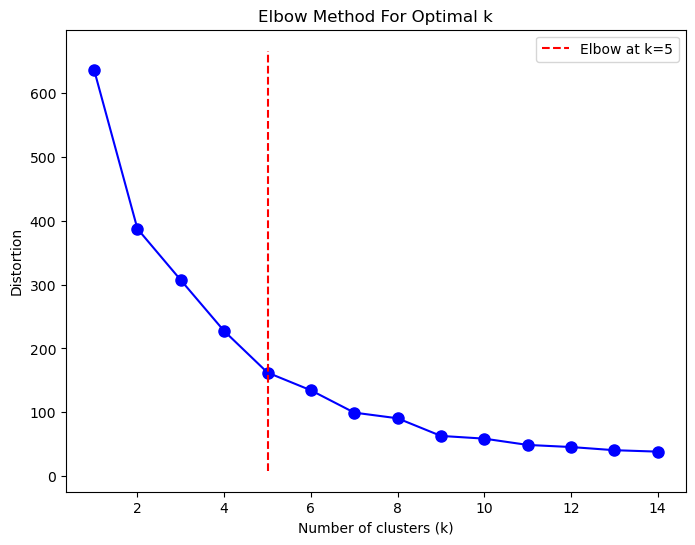

In [7]:
# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.vlines(c, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Elbow at k={c}')
plt.legend()
plt.show()

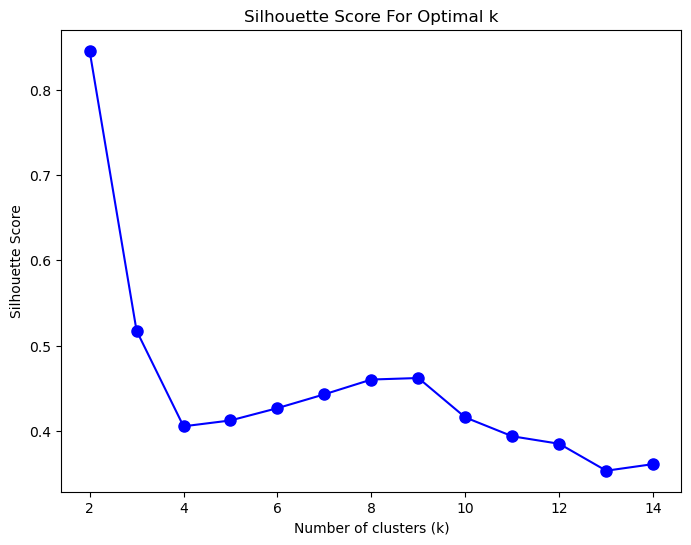

In [23]:
# Initialize the range of clusters
K = range(2, 15)  # Silhouette score is not defined for k=1
silhouette_scores = []

# Calculate silhouette scores for each value of k
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

From the elbow plot, it's evident that the distortion levels off after 5 clusters, which aligns with the optimal number of clusters suggested by kl.elbow. Although the silhouette score continues to improve from 4 to 9 clusters, indicating better-defined clusters, one could argue that the distortion curve flattens more distinctly around 9 clusters. However, for simplicity in this example, we will proceed with 5 clusters.

In [8]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

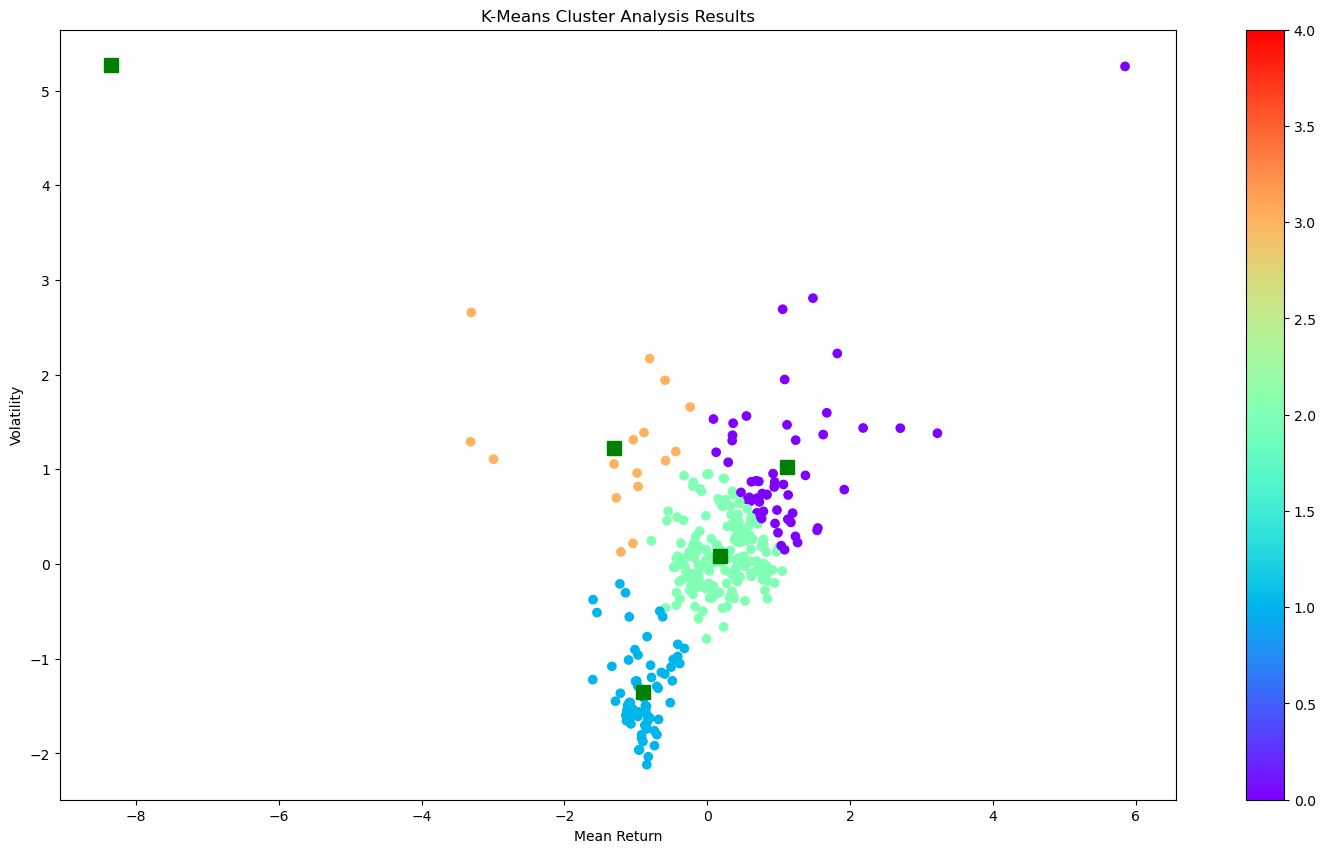

In [9]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

This plot illustrates the clusters identified by the K-means algorithm with 5 clusters. There appear to be two outliers, each positioned in the corners of the plot. Notably, one of these outliers in the top left corner was identified as a separate cluster.

In [10]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:7]

Ticker
AADR    2
AAXJ    2
ACWI    2
ACWX    2
AGNG    2
AGZD    1
AIA     2
dtype: int32

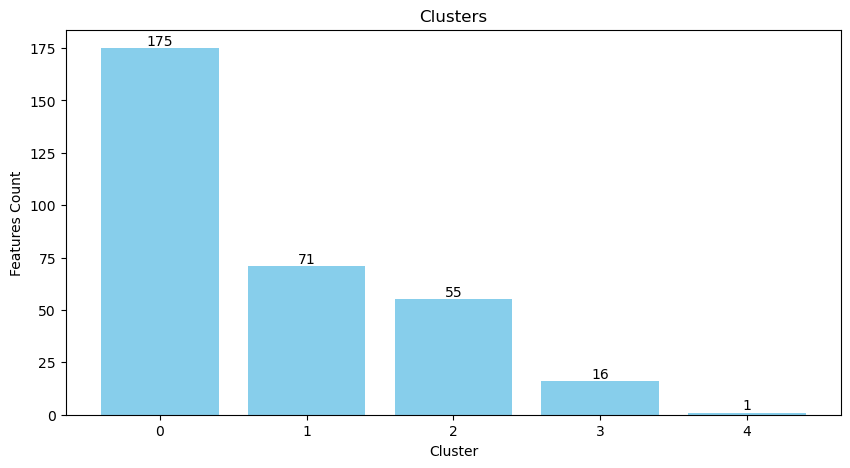

In [24]:
plt.figure(figsize=(10, 5))

# Plot the bar chart
bars = plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts(), color='skyblue')

# Add text annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Add titles and labels
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")

# Show the plot
plt.show()

This plot shows the distribution of features across the clusters. Cluster 0 contains 175 features, while Cluster 4, which corresponds to the outlier in the corner, contains only a single feature.

In [27]:
# Filter clusters with fewer than 3 features
clusters_clean = clustered_series[clustered_series < 4]

# Print the number of features before and after filtering
print(f"Number of Features Before Filtering: {len(clustered_series)}")
print(f"Number of Features After Filtering: {len(clusters_clean)}")

Number of Features Before Filtering: 318
Number of Features After Filtering: 317


We eliminate the outlier by dropping the cluster with a single feature.

### Calculate Cointegration

In [13]:
# Calculate cointegration
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio

In [14]:
# Loop through and calculate cointegrated pairs
# Allow 10 - 30 mins for calculation 
tested_pairs = []
cointegrated_pairs = []


for base_asset in clusters_clean.index:
    base_label = clusters_clean[base_asset]
        
    for compare_asset in clusters_clean.index:
        compare_label = clusters_clean[compare_asset]
            
        test_pair = base_asset + compare_asset
        test_pair = ''.join(sorted(test_pair))
        is_tested = test_pair in tested_pairs
        tested_pairs.append(test_pair)
            
        if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
            series_1 = data[base_asset].values.astype(float)
            series_2 = data[compare_asset].values.astype(float)
            coint_flag, _ = calculate_cointegration(series_1, series_2)
            if coint_flag == 1:
                cointegrated_pairs.append({"base_asset": base_asset, "compare_asset": compare_asset, "label": base_label})
                    
df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")

### TSNE Plot

In [15]:
# Get unique list of cointegrated assets
coint_assets = [df_coint["base_asset"].values]
coint_assets.append(df_coint["compare_asset"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AADR', 'AAXJ', 'ACWX', 'AGNG', 'AGZD'], dtype=object)

In [16]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility
Ticker,,
AADR,-0.186171,0.218581
AAXJ,-0.336694,0.012358
ACWX,-0.113009,-0.195715
AGNG,0.113131,-0.320228
AGZD,-0.739977,-1.760023


In [17]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

array([[ -4.4918585,   4.249423 ],
       [-11.571516 ,  15.631654 ],
       [ -6.558762 ,  37.78709  ],
       [  4.5577955,  44.740448 ],
       [-49.665165 ,  -1.5642657]], dtype=float32)

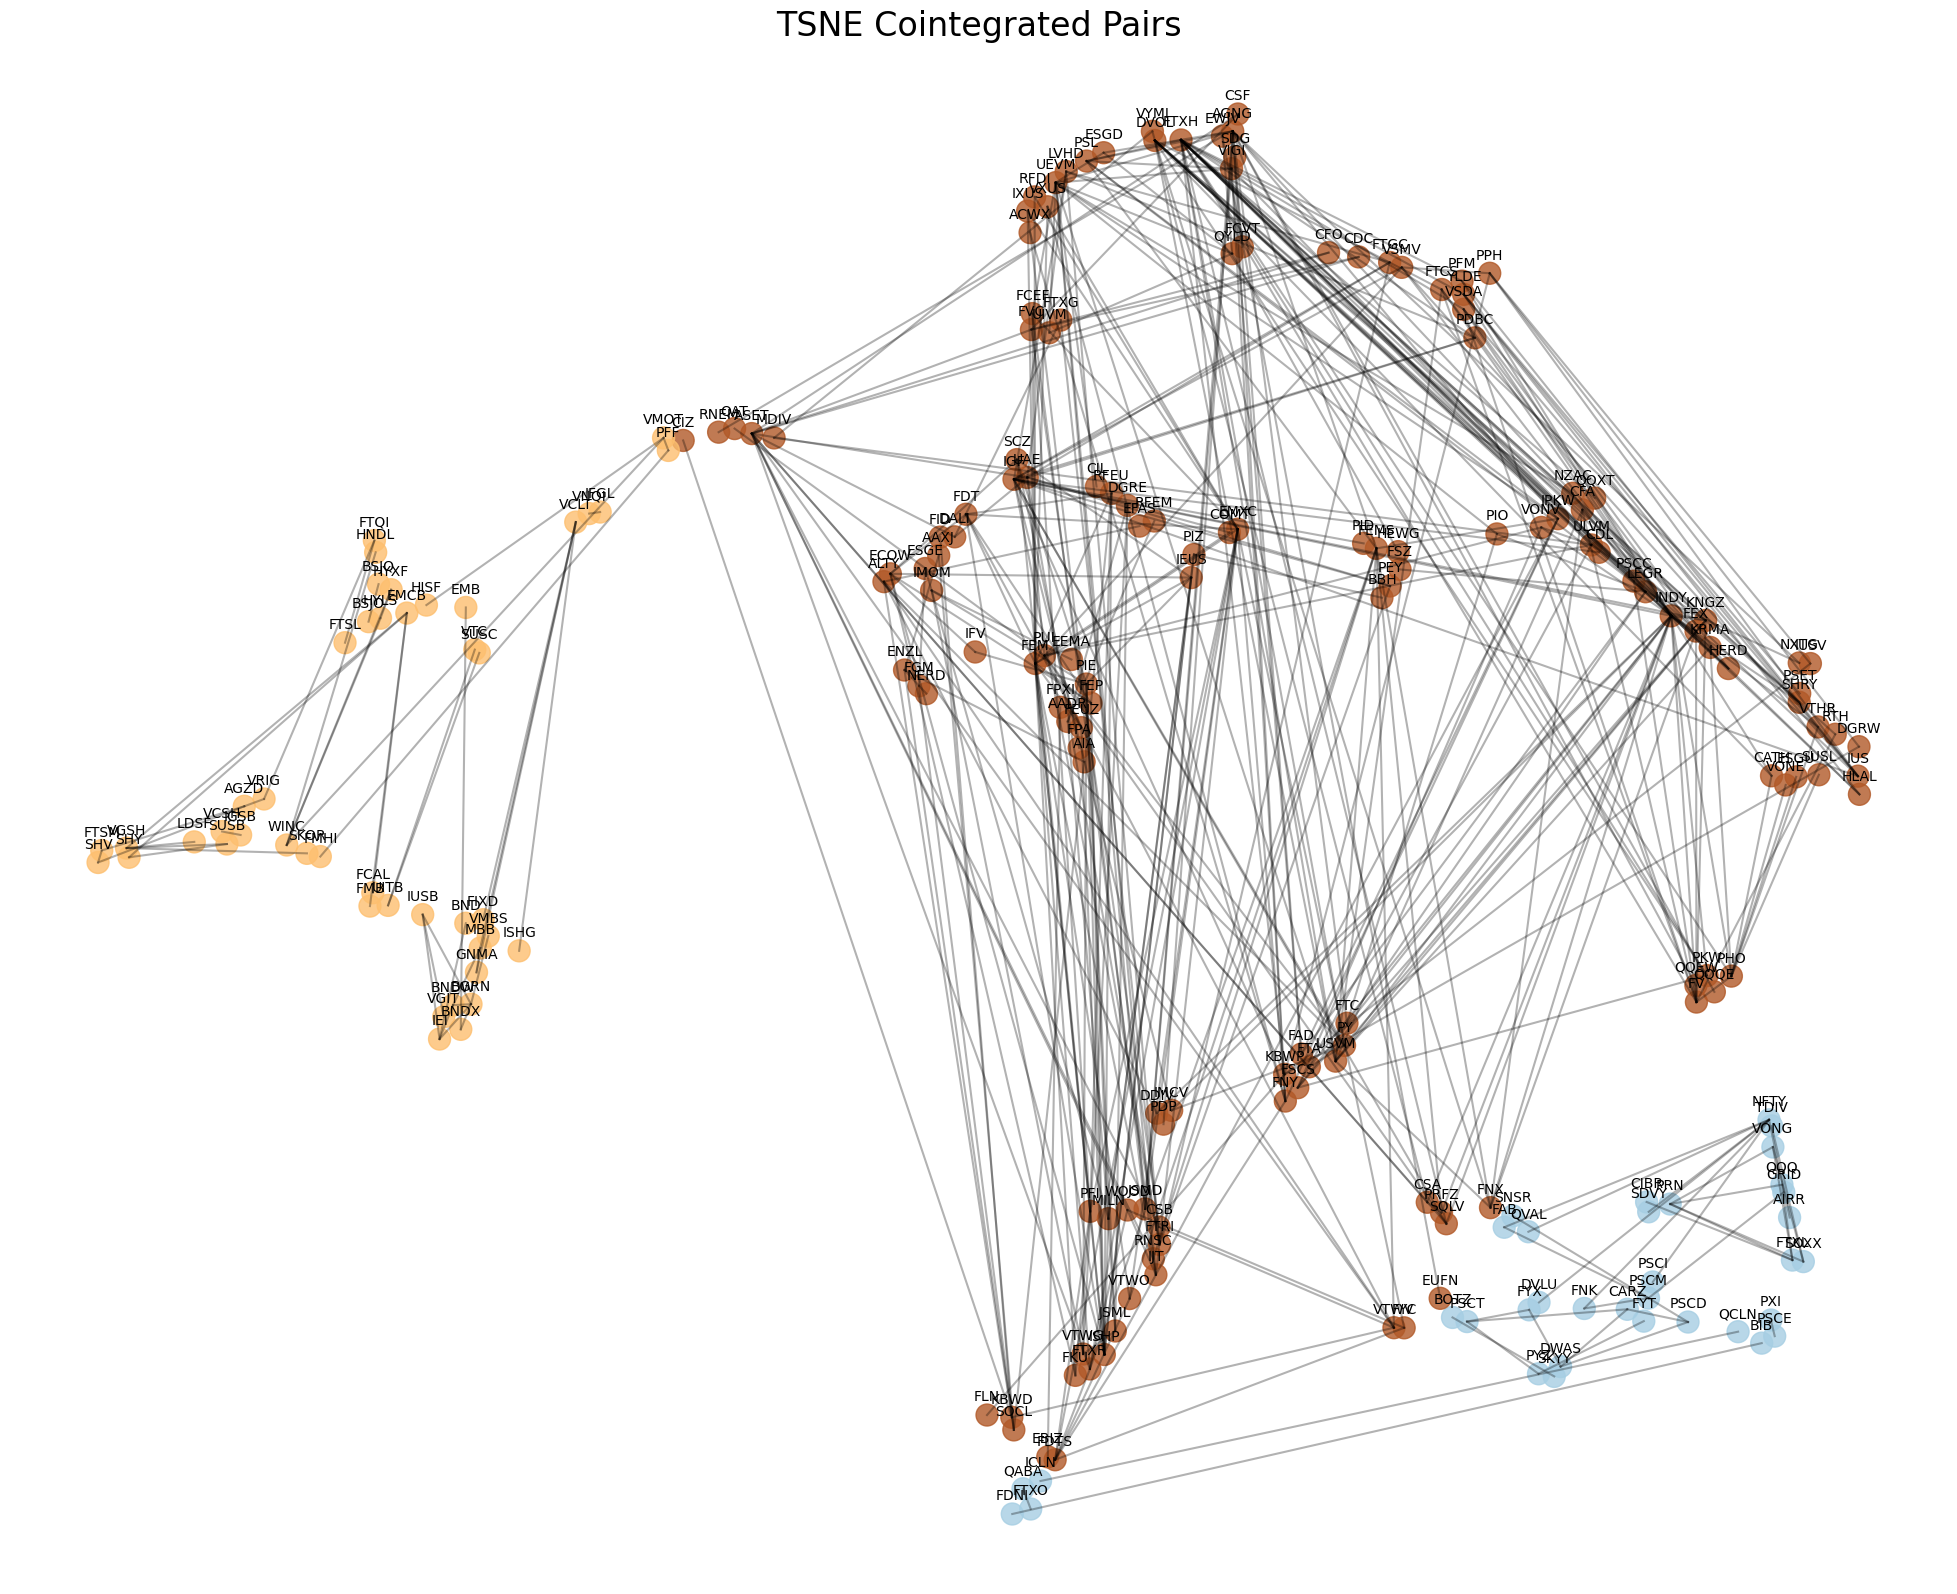

<Figure size 640x480 with 0 Axes>

In [37]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=250, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs', fontsize=24)

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()

This is a t-SNE (t-Distributed Stochastic Neighbor Embedding) plot that visualizes the relationships between the different assets, based on their cointegration.  The clusters represent groups of assets that are likely to move together over time due to their cointegration.  The lines connecting pairs of points indicate cointegrated pairs, meaning that these pairs have a statistical relationship where their price movements are linked over time.
The density and overlap of these lines suggest the strength of cointegration. Areas with many lines are likely to have more robust or significant cointegrations, which might be worth investigating further for pairs trading or hedging strategies.  The points in the plot are color-coded, representing the different clusters.

Traders or analysts might use this plot to identify pairs of assets for pairs trading strategies, where they simultaneously buy and sell two cointegrated assets to profit from their relationship.  The plot could also guide portfolio diversification by highlighting groups of assets that are likely to move together, reducing the need to include multiple assets from the same cluster in a diversified portfolio.

### Review a Pair

I chose QQQ and GRID for this example due to their high level of cointegration, and because I trade QQQ frequently.

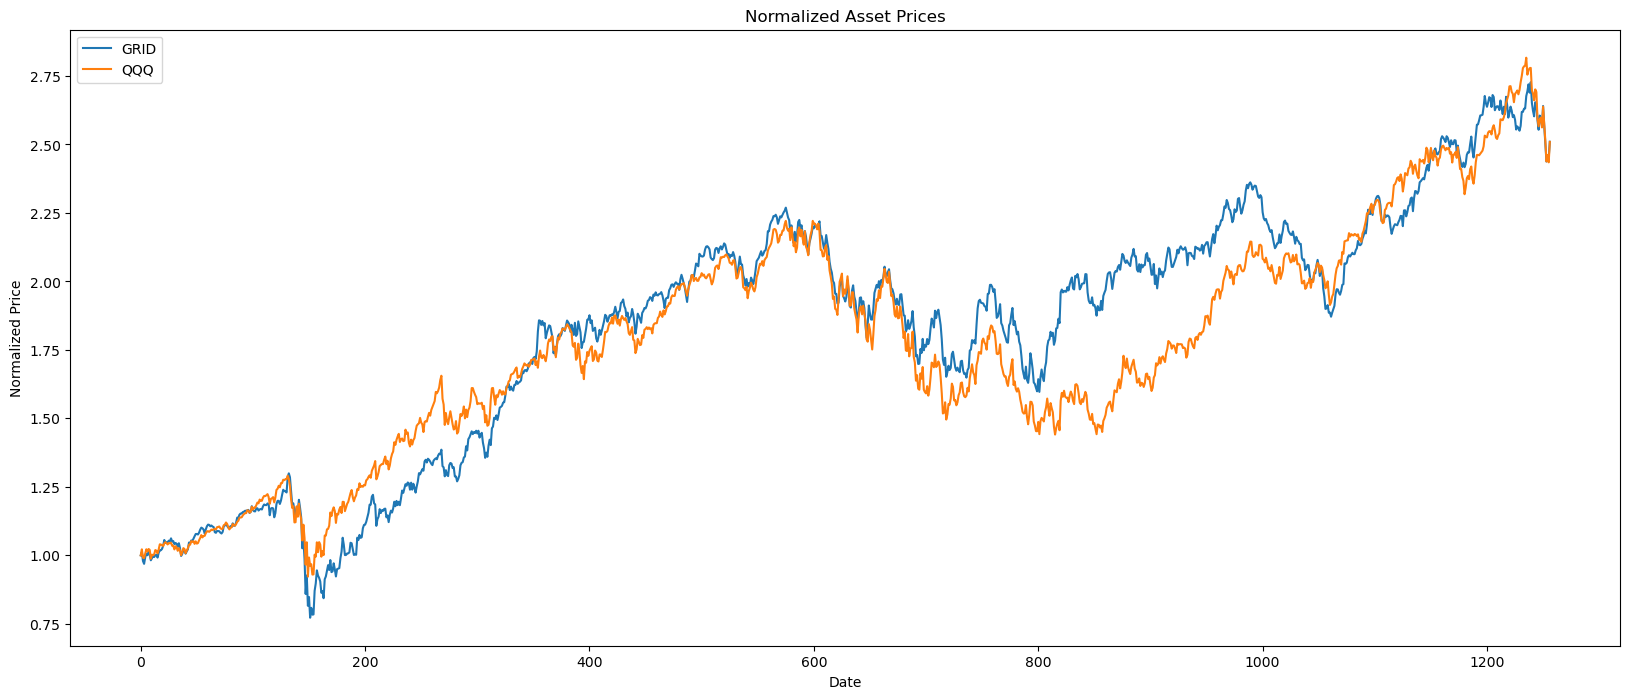

In [19]:
# Plot price comparison for any given assets
asset_1 = "GRID"
asset_2 = "QQQ"

# Normalize the data
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()

# Plot the normalized data with labels
plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values, label=asset_1)
plt.plot(asset_2_values, label=asset_2)

# Add legend
plt.legend()

# Add titles and labels if desired
plt.title('Normalized Asset Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')

# Show the plot
plt.show()

Plotting the normalized prices of the two assets reveals that they generally move in the same direction. When deviations occur, the prices tend to reconverge over time.

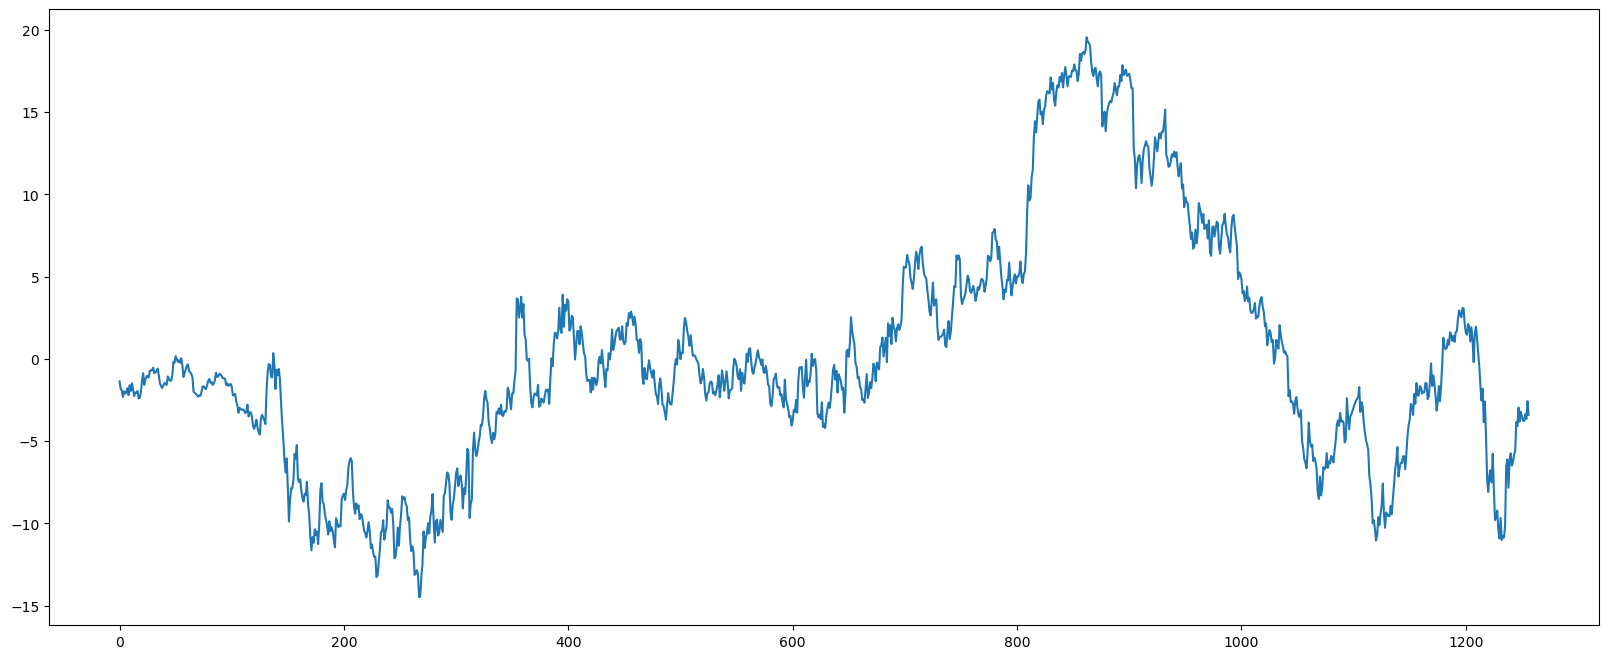

In [20]:
# Plot the Spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)
plt.figure(1, figsize=(20, 8))
plt.plot(spread)
plt.show()

The spread exhibits mean-reverting behavior, where it oscillates around a central value (mean). This is a typical characteristic of cointegrated pairs, as their relationship tends to revert to a long-term equilibrium.
The spread doesn't trend indefinitely in one direction, suggesting that the two assets have a stable long-term relationship.

The spread shows varying levels of volatility over time. There are periods of low volatility where the spread is relatively stable, followed by periods of high volatility where the spread widens and narrows more dramatically.
Higher volatility in the spread might be indicative of external market shocks, changes in the relationship between the assets, or mispricings that could present trading opportunities.

In pairs trading, large deviations from the mean (both positive and negative) are often considered potential trading signals. A trader might look to short the spread when it is significantly above the mean and long the spread when it is significantly below the mean, anticipating that the spread will revert to its historical average.
The timing and execution of these trades would depend on factors like the degree of deviation, transaction costs, and the speed of mean reversion.

The spread is calculated using a hedge ratio, which is typically derived from the cointegration relationship. This ratio ensures that the spread accurately reflects the relative movement between the two assets.
Changes in the hedge ratio over time might affect the spread, especially if the cointegration relationship changes or if the assets start to diverge.

For pairs trading to be effective, the spread should ideally be stationary, meaning it has a constant mean and variance over time. The plot suggests that the spread is likely stationary, given its tendency to revert to a mean and its bounded volatility.
Stationarity can be formally tested using statistical tests like the Augmented Dickey-Fuller (ADF) test, which would confirm whether the spread is a valid basis for a pairs trading strategy.

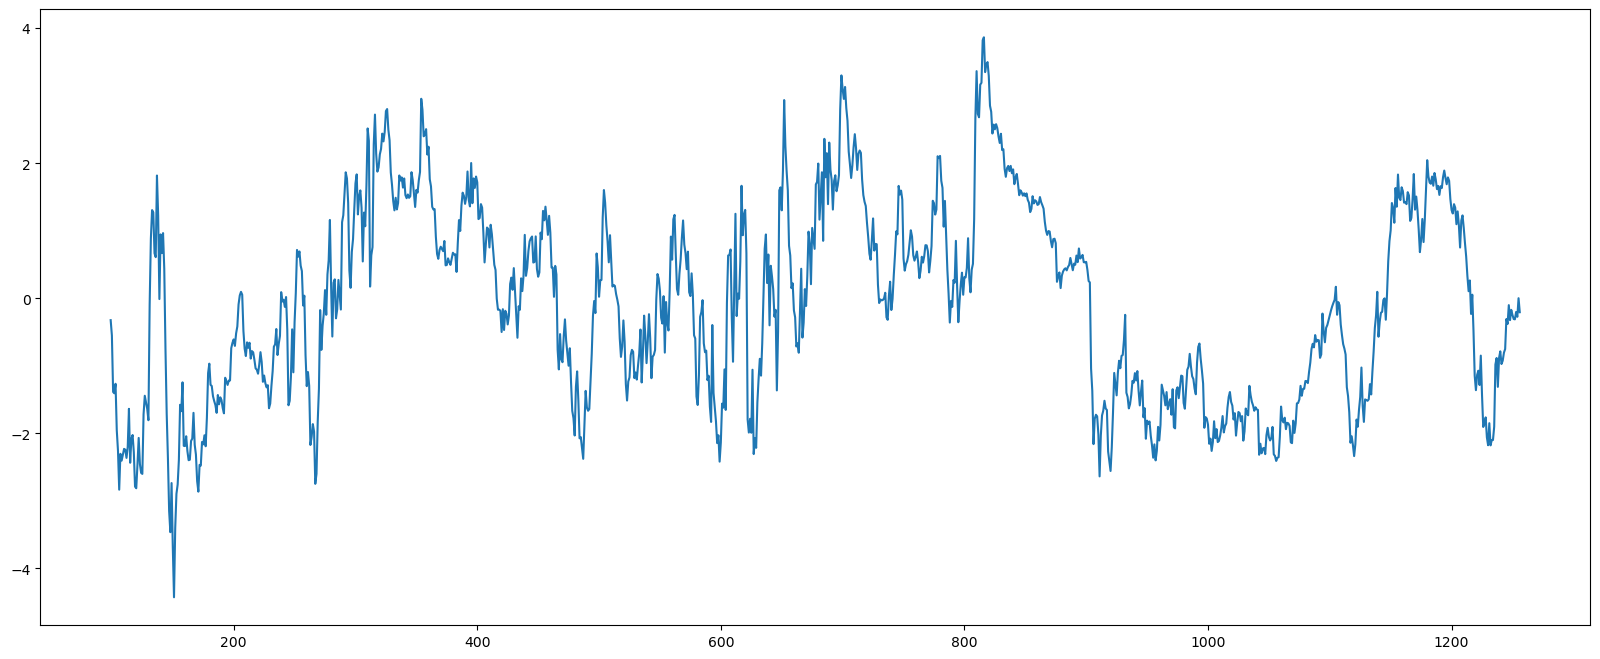

In [21]:
# Plot the ZScore
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std
plt.figure(1, figsize=(20, 8))
plt.plot(z_score)
plt.show()

The Z-score oscillates around 0, which is typical for a mean-reverting time series. This indicates that the spread is likely stationary, with the Z-score reverting to the mean over time.  In pairs trading, this behavior is desirable because it suggests that the spread between the two assets tends to return to its historical average, providing potential trading signals when it deviates significantly.

Traders often use Z-score thresholds to determine entry and exit points for trades. For example, if the Z-score crosses +2 or -2, it might indicate that the spread is significantly overbought or oversold, suggesting a potential reversal.
The plot shows several instances where the Z-score moves beyond typical thresholds (like ±2 or ±3), which could signal potential trade opportunities.

The plot reveals periods of higher and lower volatility in the Z-score. High volatility periods (where the Z-score fluctuates more dramatically) might indicate increased market activity or external factors affecting the spread.
During low volatility periods, the Z-score remains closer to 0, suggesting that the assets are moving in closer alignment.

The Z-score is calculated using a rolling window (in this case, 100 periods). The choice of the window length can significantly impact the smoothness of the Z-score and the timing of signals.
A shorter window would produce a more responsive but potentially noisier Z-score, while a longer window would smooth out the Z-score but might delay signals.

A common strategy is to enter a long position in the spread when the Z-score is below a negative threshold (e.g., -2) and exit when it returns to 0 or crosses a positive threshold (e.g., +2).
Conversely, one might enter a short position when the Z-score is above a positive threshold and exit when it returns to 0 or crosses a negative threshold.
The Z-score also helps in risk management, as extreme values could indicate a higher risk of the spread not reverting as expected.

### References

Cluster Analysis – Machine Learning for Pairs Trading by Igor Radovanovic https://algotrading101.com/learn/cluster-analysis-guide/